# Description

It analyzes different strategies to take the genes from GTEx data with the highest variability, being this variability measured with different strategies: variance (`var`), coefficient of variation (`cv`) and mean absolute variation (`mad`) applied on two different versions of the data: 1) the raw TPM-normalized gene expression data (here refered to as `raw`), and 2) the log2-transformed version of the raw data (here refered to as `log2` and `pc_log2`).

# Modules

In [1]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from tqdm import tqdm

from ccc import conf

# Settings

In [2]:
N_TOP_GENES_MAX_VARIANCE = 5000

# Paths

In [3]:
INPUT_DIR = conf.GTEX["DATA_DIR"] / "data_by_tissue"
display(INPUT_DIR)

PosixPath('/opt/data/data/gtex_v8/data_by_tissue')

In [4]:
OUTPUT_DIR = conf.GTEX["GENE_SELECTION_DIR"]
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
display(OUTPUT_DIR)

PosixPath('/opt/data/results/gtex_v8/gene_selection')

# Functions

In [5]:
PCA_OPTIONS = {
    "n_components": 5,
    "random_state": 0,
}

In [6]:
def standardize(data):
    return pd.DataFrame(
        data=scale(data),
        index=data.index.copy(),
        columns=data.columns.copy(),
    )

In [7]:
def plot_pca(data, std=True):
    if std:
        data = standardize(data)

    clf = PCA(**PCA_OPTIONS)
    pca_data = clf.fit_transform(data)

    pca_data = pd.DataFrame(
        data=pca_data,
        index=data.index.copy(),
        columns=[f"PCA{i+1}" for i in range(pca_data.shape[1])],
    )

    g = sns.pairplot(data=pca_data)
    display(g)

# Compare different criteria to select highly variable genes

In [8]:
# I will store here the top genes selected by each method
top_genes_var = {}

## Get test data

In [9]:
test_data = pd.read_pickle(INPUT_DIR / "gtex_v8_data_whole_blood.pkl")

In [10]:
test_data.shape

(56200, 755)

In [11]:
test_data.head()

,GTEX-111YS-0006-SM-5NQBE,GTEX-1122O-0005-SM-5O99J,GTEX-1128S-0005-SM-5P9HI,GTEX-113IC-0006-SM-5NQ9C,GTEX-113JC-0006-SM-5O997,GTEX-117XS-0005-SM-5PNU6,GTEX-117YW-0005-SM-5NQ8Z,GTEX-1192W-0005-SM-5NQBQ,GTEX-1192X-0005-SM-5NQC3,GTEX-11DXW-0006-SM-5NQ7Y,...,GTEX-ZVE2-0006-SM-51MRW,GTEX-ZVP2-0005-SM-51MRK,GTEX-ZVT2-0005-SM-57WBW,GTEX-ZVT3-0006-SM-51MT9,GTEX-ZVT4-0006-SM-57WB8,GTEX-ZVTK-0006-SM-57WBK,GTEX-ZVZP-0006-SM-51MSW,GTEX-ZVZQ-0006-SM-51MR8,GTEX-ZXES-0005-SM-57WCB,GTEX-ZXG5-0005-SM-57WCN
gene_ens_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972.5,0.02171,0.03015,0.0203,0.1675,0.02104,0.02537,0.02492,0.06809,0.0000,0.02443,...,0.0000,0.04841,0.00000,0.000,0.04858,0.11450,0.02417,0.000,0.02128,0.0000
ENSG00000227232.5,1.55500,2.74700,4.4410,10.4700,1.28700,3.13800,4.21700,2.09800,0.3579,4.26200,...,0.8979,3.06700,2.46400,1.504,3.19400,2.90600,3.43000,4.169,2.74300,6.0720
ENSG00000278267.1,0.00000,0.00000,0.0000,0.0000,0.00000,0.00000,0.00000,0.00000,0.0000,0.62120,...,0.0000,0.00000,0.65930,0.000,0.00000,0.00000,0.00000,0.000,0.00000,0.6112
ENSG00000243485.5,0.00000,0.00000,0.0000,0.0000,0.00000,0.00000,0.00000,0.04532,0.0000,0.00000,...,0.0000,0.00000,0.00000,0.000,0.09698,0.11430,0.00000,0.000,0.00000,0.0000
ENSG00000237613.2,0.00000,0.00000,0.0576,0.0000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,...,0.0000,0.00000,0.03678,0.000,0.00000,0.04058,0.00000,0.000,0.00000,0.0000


In [12]:
test_data_desc = pd.Series(test_data.to_numpy().flatten()).describe()
display(test_data_desc)

assert test_data_desc["min"] == 0.0
assert test_data_desc["max"] < 7.5e5

count    4.243100e+07
mean     1.779361e+01
std      1.454826e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      5.264000e-01
max      7.474000e+05
dtype: float64

## Get test data in log2

Here I attempt a direct log transformation without any change to the raw data, and replacing -inf values by the minimum.

In [13]:
log2_test_data = np.log2(test_data)

In [14]:
log2_test_data.shape

(56200, 755)

In [15]:
log2_test_data.head()

,GTEX-111YS-0006-SM-5NQBE,GTEX-1122O-0005-SM-5O99J,GTEX-1128S-0005-SM-5P9HI,GTEX-113IC-0006-SM-5NQ9C,GTEX-113JC-0006-SM-5O997,GTEX-117XS-0005-SM-5PNU6,GTEX-117YW-0005-SM-5NQ8Z,GTEX-1192W-0005-SM-5NQBQ,GTEX-1192X-0005-SM-5NQC3,GTEX-11DXW-0006-SM-5NQ7Y,...,GTEX-ZVE2-0006-SM-51MRW,GTEX-ZVP2-0005-SM-51MRK,GTEX-ZVT2-0005-SM-57WBW,GTEX-ZVT3-0006-SM-51MT9,GTEX-ZVT4-0006-SM-57WB8,GTEX-ZVTK-0006-SM-57WBK,GTEX-ZVZP-0006-SM-51MSW,GTEX-ZVZQ-0006-SM-51MR8,GTEX-ZXES-0005-SM-57WCB,GTEX-ZXG5-0005-SM-57WCN
gene_ens_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972.5,-5.525496,-5.051698,-5.622376,-2.577767,-5.570721,-5.300733,-5.326552,-3.876413,-inf,-5.355202,...,-inf,-4.368551,-inf,-inf,-4.363494,-3.126580,-5.370639,-inf,-5.554358,-inf
ENSG00000227232.5,0.636915,1.457857,2.150885,3.388190,0.364012,1.649845,2.076217,1.069015,-1.482372,2.091531,...,-0.155373,1.616828,1.301002,0.588805,1.675364,1.539035,1.778209,2.059701,1.455755,2.602172
ENSG00000278267.1,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-0.686870,...,-inf,-inf,-0.600993,-inf,-inf,-inf,-inf,-inf,-inf,-0.710284
ENSG00000243485.5,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-4.463708,-inf,-inf,...,-inf,-inf,-inf,-inf,-3.366169,-3.129103,-inf,-inf,-inf,-inf
ENSG00000237613.2,-inf,-inf,-4.117787,-inf,-inf,-inf,-inf,-inf,-inf,-inf,...,-inf,-inf,-4.764935,-inf,-inf,-4.623087,-inf,-inf,-inf,-inf


In [16]:
# get minimum values by removing -np.inf first
sample_min_values = (
    pd.Series(log2_test_data.replace(-np.inf, np.nan).to_numpy().flatten())
    .dropna()
    .sort_values()
)

In [17]:
sample_min_values.head()

26101540   -13.293640
26101140   -13.172679
26101515   -12.882809
26101651   -12.836699
26101126   -12.823044
dtype: float64

In [18]:
# get the min value and replace -np.inf by it
log2_min_value = sample_min = sample_min_values.iloc[0]
display(log2_min_value)
assert log2_min_value < -13.0
assert log2_min_value > -13.5

-13.29363958831516

In [19]:
log2_test_data = log2_test_data.replace(-np.inf, log2_min_value * 1.3)

In [20]:
log2_test_data.shape

(56200, 755)

In [21]:
assert (
    log2_test_data.iloc[:, [0]].squeeze().loc["ENSG00000278267.1"].round(5) == -17.28173
)

In [22]:
log2_test_data.head()

,GTEX-111YS-0006-SM-5NQBE,GTEX-1122O-0005-SM-5O99J,GTEX-1128S-0005-SM-5P9HI,GTEX-113IC-0006-SM-5NQ9C,GTEX-113JC-0006-SM-5O997,GTEX-117XS-0005-SM-5PNU6,GTEX-117YW-0005-SM-5NQ8Z,GTEX-1192W-0005-SM-5NQBQ,GTEX-1192X-0005-SM-5NQC3,GTEX-11DXW-0006-SM-5NQ7Y,...,GTEX-ZVE2-0006-SM-51MRW,GTEX-ZVP2-0005-SM-51MRK,GTEX-ZVT2-0005-SM-57WBW,GTEX-ZVT3-0006-SM-51MT9,GTEX-ZVT4-0006-SM-57WB8,GTEX-ZVTK-0006-SM-57WBK,GTEX-ZVZP-0006-SM-51MSW,GTEX-ZVZQ-0006-SM-51MR8,GTEX-ZXES-0005-SM-57WCB,GTEX-ZXG5-0005-SM-57WCN
gene_ens_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972.5,-5.525496,-5.051698,-5.622376,-2.577767,-5.570721,-5.300733,-5.326552,-3.876413,-17.281731,-5.355202,...,-17.281731,-4.368551,-17.281731,-17.281731,-4.363494,-3.126580,-5.370639,-17.281731,-5.554358,-17.281731
ENSG00000227232.5,0.636915,1.457857,2.150885,3.388190,0.364012,1.649845,2.076217,1.069015,-1.482372,2.091531,...,-0.155373,1.616828,1.301002,0.588805,1.675364,1.539035,1.778209,2.059701,1.455755,2.602172
ENSG00000278267.1,-17.281731,-17.281731,-17.281731,-17.281731,-17.281731,-17.281731,-17.281731,-17.281731,-17.281731,-0.686870,...,-17.281731,-17.281731,-0.600993,-17.281731,-17.281731,-17.281731,-17.281731,-17.281731,-17.281731,-0.710284
ENSG00000243485.5,-17.281731,-17.281731,-17.281731,-17.281731,-17.281731,-17.281731,-17.281731,-4.463708,-17.281731,-17.281731,...,-17.281731,-17.281731,-17.281731,-17.281731,-3.366169,-3.129103,-17.281731,-17.281731,-17.281731,-17.281731
ENSG00000237613.2,-17.281731,-17.281731,-4.117787,-17.281731,-17.281731,-17.281731,-17.281731,-17.281731,-17.281731,-17.281731,...,-17.281731,-17.281731,-4.764935,-17.281731,-17.281731,-4.623087,-17.281731,-17.281731,-17.281731,-17.281731


In [23]:
log2_test_data.iloc[:10, :].T.describe()

gene_ens_id,ENSG00000223972.5,ENSG00000227232.5,ENSG00000278267.1,ENSG00000243485.5,ENSG00000237613.2,ENSG00000268020.3,ENSG00000240361.1,ENSG00000186092.4,ENSG00000238009.6,ENSG00000233750.3
count,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000
mean,-11.248774,1.368299,-16.781577,-15.135777,-15.478569,-14.152947,-12.580850,-12.444420,-4.526458,-0.629806
std,6.385271,1.176228,2.825503,4.827639,4.374485,5.564669,6.248415,6.347718,4.920940,2.126796
min,-17.281731,-17.281731,-17.281731,-17.281731,-17.281731,-17.281731,-17.281731,-17.281731,-17.281731,-17.281731
25%,-17.281731,0.860750,-17.281731,-17.281731,-17.281731,-17.281731,-17.281731,-17.281731,-4.965798,-1.849444
50%,-17.281731,1.404358,-17.281731,-17.281731,-17.281731,-17.281731,-17.281731,-17.281731,-3.374225,-0.330066
75%,-4.825701,2.044393,-17.281731,-17.281731,-17.281731,-17.281731,-4.775375,-4.683171,-1.657218,0.842375
max,-1.299383,4.090853,1.459432,-1.427401,-2.641154,-2.189680,-1.444969,0.975997,2.269033,3.155102


In [24]:
# get some stats
log2_test_data_desc = pd.Series(log2_test_data.to_numpy().flatten()).describe()
display(log2_test_data_desc)

count    4.243100e+07
mean    -9.570422e+00
std      8.880062e+00
min     -1.728173e+01
25%     -1.728173e+01
50%     -1.728173e+01
75%     -9.257686e-01
max      1.951152e+01
dtype: float64

## Get test data in log2 after pseudocount

Here I try another approach to log-transform the data by using pseudocounts. See:
 - https://github.com/greenelab/ccc/pull/4#discussion_r698793383

In [25]:
log2_pc_test_data = np.log2(test_data + 1)

In [26]:
log2_pc_test_data.shape

(56200, 755)

In [27]:
# get some stats
log2_pc_test_data_desc = pd.Series(log2_pc_test_data.to_numpy().flatten()).describe()
display(log2_pc_test_data_desc)

count    4.243100e+07
mean     7.783040e-01
std      1.613763e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      6.101331e-01
max      1.951152e+01
dtype: float64

In [28]:
log2_pc_test_data.head()

,GTEX-111YS-0006-SM-5NQBE,GTEX-1122O-0005-SM-5O99J,GTEX-1128S-0005-SM-5P9HI,GTEX-113IC-0006-SM-5NQ9C,GTEX-113JC-0006-SM-5O997,GTEX-117XS-0005-SM-5PNU6,GTEX-117YW-0005-SM-5NQ8Z,GTEX-1192W-0005-SM-5NQBQ,GTEX-1192X-0005-SM-5NQC3,GTEX-11DXW-0006-SM-5NQ7Y,...,GTEX-ZVE2-0006-SM-51MRW,GTEX-ZVP2-0005-SM-51MRK,GTEX-ZVT2-0005-SM-57WBW,GTEX-ZVT3-0006-SM-51MT9,GTEX-ZVT4-0006-SM-57WB8,GTEX-ZVTK-0006-SM-57WBK,GTEX-ZVZP-0006-SM-51MSW,GTEX-ZVZQ-0006-SM-51MR8,GTEX-ZXES-0005-SM-57WCB,GTEX-ZXG5-0005-SM-57WCN
gene_ens_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972.5,0.030986,0.042854,0.028993,0.223423,0.030039,0.036145,0.035511,0.095033,0.000000,0.034821,...,0.000000,0.068203,0.000000,0.000000,0.068437,0.156397,0.034455,0.000000,0.030378,0.000000
ENSG00000227232.5,1.353323,1.905736,2.443872,3.519793,1.193456,2.048934,2.383220,1.631337,0.441377,2.395611,...,0.924404,2.023965,1.792439,1.324235,2.068327,1.965692,2.147307,2.369885,1.904195,2.822118
ENSG00000278267.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.697062,...,0.000000,0.000000,0.730575,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.688136
ENSG00000243485.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.063945,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.133537,0.156138,0.000000,0.000000,0.000000,0.000000
ENSG00000237613.2,0.000000,0.000000,0.080794,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.052110,0.000000,0.000000,0.057388,0.000000,0.000000,0.000000,0.000000


## On TPM-normalized data (raw)

### Variance

In [29]:
exp_id = "var_raw"

In [30]:
top_genes_var[exp_id] = (
    test_data.var(axis=1).sort_values(ascending=False).head(N_TOP_GENES_MAX_VARIANCE)
)

In [31]:
top_genes_var[exp_id]

gene_ens_id
ENSG00000244734.3     2.359712e+10
ENSG00000188536.12    2.212349e+09
ENSG00000163220.10    1.403840e+09
ENSG00000206172.8     1.801360e+08
ENSG00000223609.7     9.886324e+07
                          ...     
ENSG00000130517.13    6.785128e+01
ENSG00000138674.16    6.784771e+01
ENSG00000065911.11    6.778009e+01
ENSG00000163297.16    6.777261e+01
ENSG00000259865.1     6.773850e+01
Length: 5000, dtype: float64

Here I take a quick look at how these selected genes look like in a PCA plot. I do not use PCA to select genes, just a visual assessment.

In [32]:
selected_data = test_data.loc[top_genes_var[exp_id].index]

In [33]:
selected_data.shape

(5000, 755)

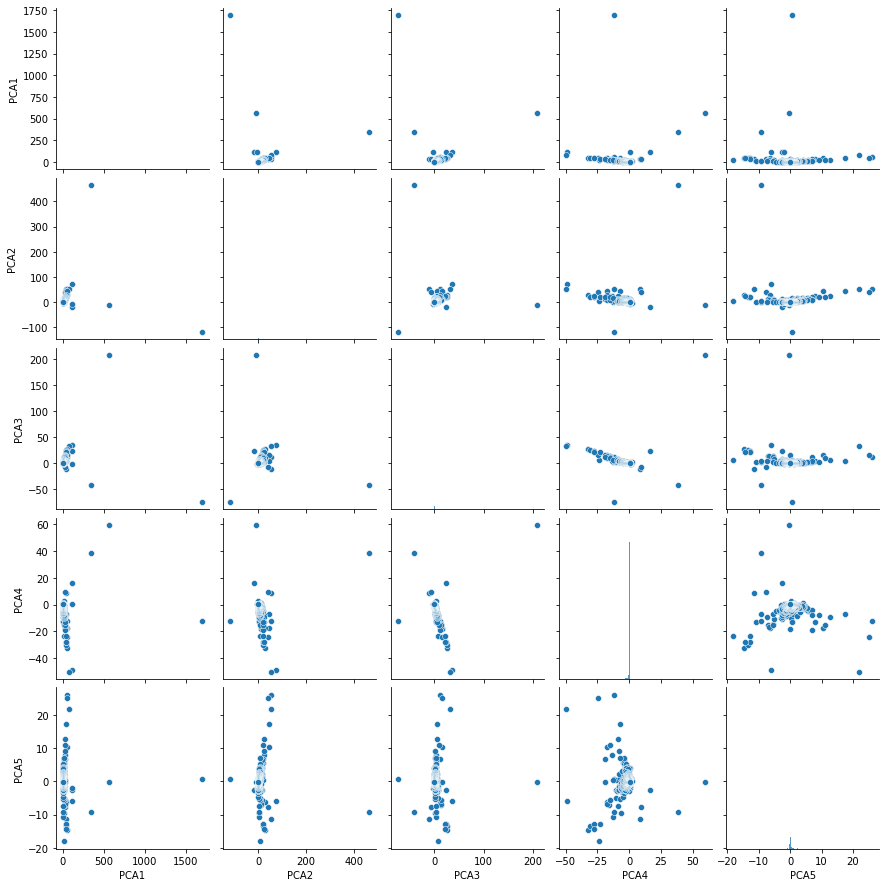

In [34]:
plot_pca(selected_data)

### Coefficient of variation

In [35]:
exp_id = "cv_raw"

In [36]:
top_genes_var[exp_id] = (
    (test_data.std(axis=1) / test_data.mean(axis=1))
    .sort_values(ascending=False)
    .head(N_TOP_GENES_MAX_VARIANCE)
)

In [37]:
top_genes_var[exp_id]

gene_ens_id
ENSG00000252644.1    27.477263
ENSG00000263890.1    27.477263
ENSG00000278945.1    27.477263
ENSG00000252750.1    27.477263
ENSG00000265168.1    27.477263
                       ...    
ENSG00000283517.1    14.829460
ENSG00000252711.1    14.828955
ENSG00000250084.1    14.825888
ENSG00000243543.8    14.822224
ENSG00000234686.1    14.819219
Length: 5000, dtype: float64

### Mean absolute variation

In [38]:
exp_id = "mad_raw"

In [39]:
top_genes_var[exp_id] = (
    test_data.mad(axis=1).sort_values(ascending=False).head(N_TOP_GENES_MAX_VARIANCE)
)

In [40]:
top_genes_var[exp_id]

gene_ens_id
ENSG00000244734.3     128806.279549
ENSG00000188536.12     38162.206489
ENSG00000163220.10     29350.347020
ENSG00000206172.8      10972.777868
ENSG00000223609.7       8083.453017
                          ...      
ENSG00000243055.1          5.824070
ENSG00000013288.8          5.823924
ENSG00000185880.12         5.822185
ENSG00000153574.8          5.817820
ENSG00000124783.12         5.814515
Length: 5000, dtype: float64

## On log2 TPM-normalized data

### Variance

In [41]:
exp_id = "var_log2"

In [42]:
top_genes_var[exp_id] = (
    log2_test_data.var(axis=1)
    .sort_values(ascending=False)
    .head(N_TOP_GENES_MAX_VARIANCE)
)

In [43]:
top_genes_var[exp_id]

gene_ens_id
ENSG00000200879.1    87.319568
ENSG00000213058.3    86.360064
ENSG00000211924.1    85.764423
ENSG00000211918.1    84.522048
ENSG00000211923.1    84.011098
                       ...    
ENSG00000229083.1    43.153524
ENSG00000107014.8    43.148485
ENSG00000131482.9    43.144884
ENSG00000279721.1    43.141531
ENSG00000277182.1    43.140081
Length: 5000, dtype: float64

Here I take a quick look at how these selected genes look like in a PCA plot. I do not use PCA to select genes, just a visual assessment.

In [44]:
# plot on raw
selected_data = test_data.loc[top_genes_var[exp_id].index]

In [45]:
selected_data.shape

(5000, 755)

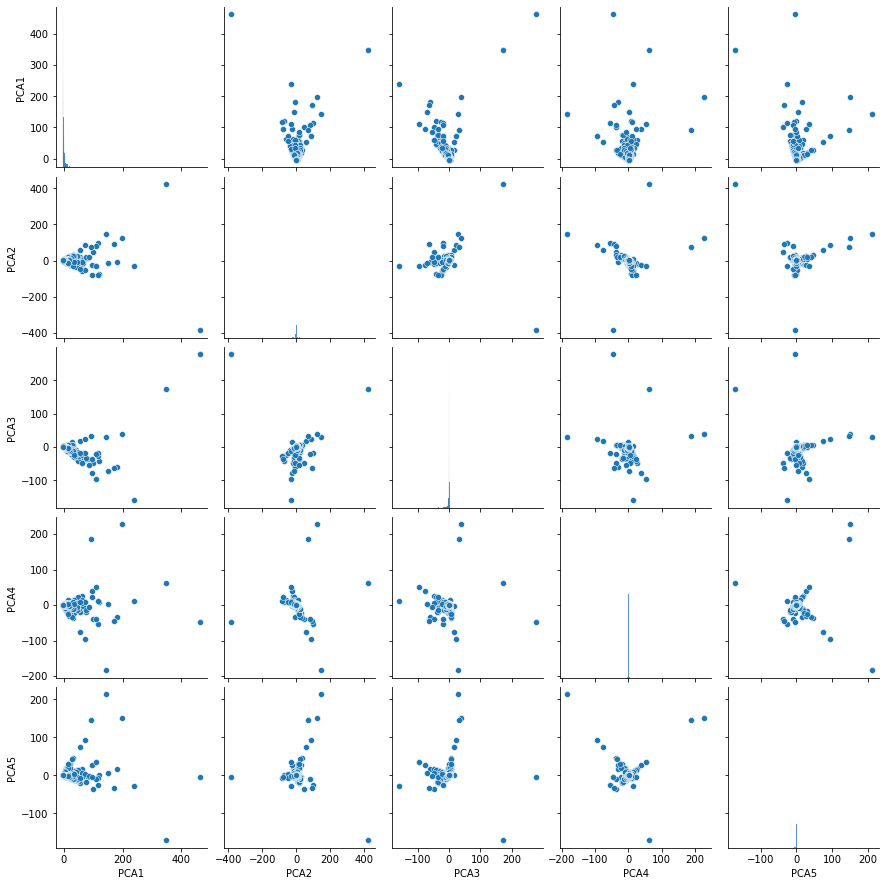

In [46]:
plot_pca(selected_data)

In [47]:
# plot on log2
selected_data = log2_test_data.loc[top_genes_var[exp_id].index]

In [48]:
selected_data.shape

(5000, 755)

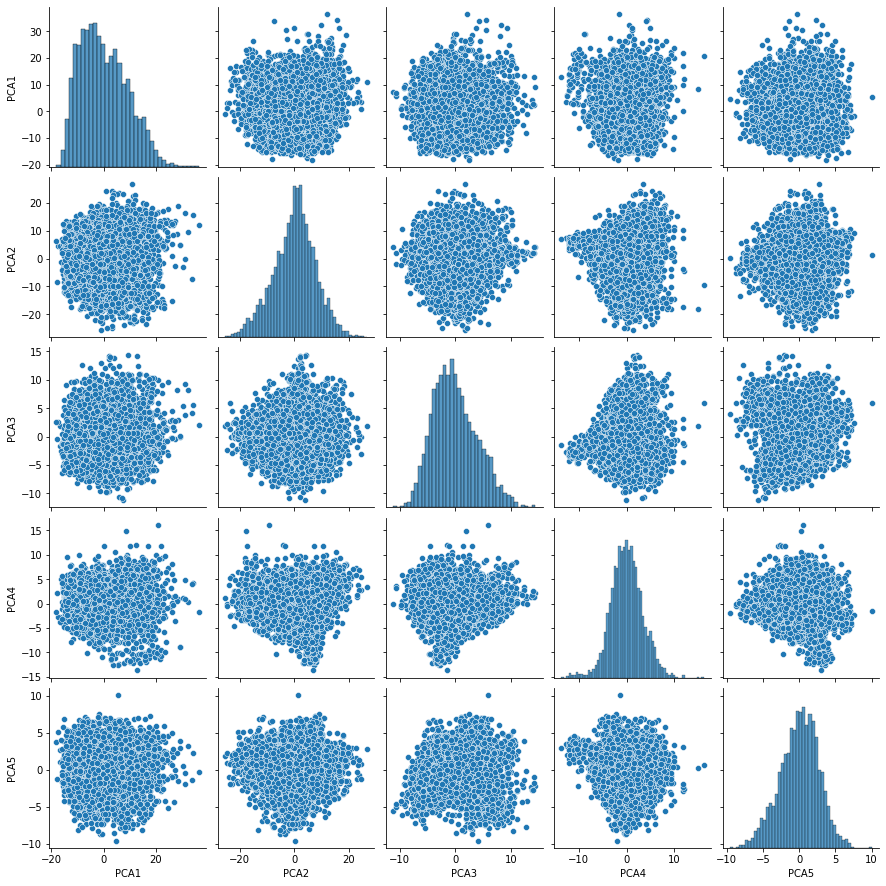

In [49]:
plot_pca(selected_data)

### Coefficient of variation

In [50]:
exp_id = "cv_log2"

In [51]:
top_genes_var[exp_id] = (
    (log2_test_data.std(axis=1) / log2_test_data.mean(axis=1))
    .sort_values(ascending=False)
    .head(N_TOP_GENES_MAX_VARIANCE)
)

In [52]:
top_genes_var[exp_id]

gene_ens_id
ENSG00000213399.3     5606.592334
ENSG00000187860.10     769.530322
ENSG00000133256.12     643.416736
ENSG00000205208.4      403.865152
ENSG00000065060.16     390.844173
                         ...     
ENSG00000100697.14       0.477970
ENSG00000023697.12       0.477924
ENSG00000146833.15       0.477659
ENSG00000172893.15       0.477517
ENSG00000257698.1        0.477370
Length: 5000, dtype: float64

### Mean absolute variation

In [53]:
exp_id = "mad_log2"

In [54]:
top_genes_var[exp_id] = (
    log2_test_data.mad(axis=1)
    .sort_values(ascending=False)
    .head(N_TOP_GENES_MAX_VARIANCE)
)

In [55]:
top_genes_var[exp_id]

gene_ens_id
ENSG00000211924.1     9.210316
ENSG00000200879.1     9.209821
ENSG00000211917.1     9.028009
ENSG00000211918.1     8.843186
ENSG00000265658.6     8.834646
                        ...   
ENSG00000092345.13    6.096868
ENSG00000255621.1     6.096620
ENSG00000253327.2     6.096240
ENSG00000104826.12    6.096180
ENSG00000267924.1     6.095797
Length: 5000, dtype: float64

## On pseudocount/log2 TPM-normalized data

### Variance

In [56]:
exp_id = "var_pc_log2"

In [57]:
top_genes_var[exp_id] = (
    log2_pc_test_data.var(axis=1)
    .sort_values(ascending=False)
    .head(N_TOP_GENES_MAX_VARIANCE)
)

In [58]:
top_genes_var[exp_id]

gene_ens_id
ENSG00000169429.10    14.739918
ENSG00000135245.9     10.913617
ENSG00000163631.16    10.291883
ENSG00000277632.1      9.706209
ENSG00000239839.6      9.440418
                        ...    
ENSG00000198478.7      0.775073
ENSG00000168137.15     0.775057
ENSG00000182197.10     0.775046
ENSG00000111641.11     0.774752
ENSG00000168528.11     0.774657
Length: 5000, dtype: float64

Here I take a quick look at how these selected genes look like in a PCA plot. I do not use PCA to select genes, just a visual assessment.

In [59]:
# plot on raw
selected_data = test_data.loc[top_genes_var[exp_id].index]

In [60]:
selected_data.shape

(5000, 755)

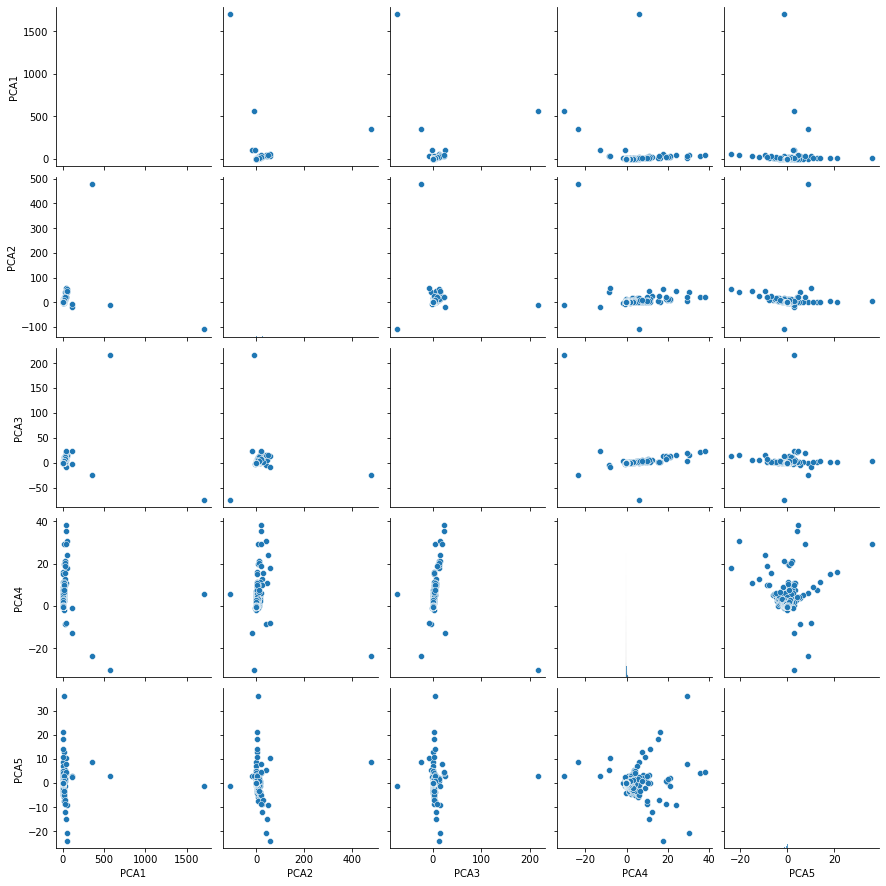

In [61]:
plot_pca(selected_data)

In [62]:
# plot on pc_log2
selected_data = log2_pc_test_data.loc[top_genes_var[exp_id].index]

In [63]:
selected_data.shape

(5000, 755)

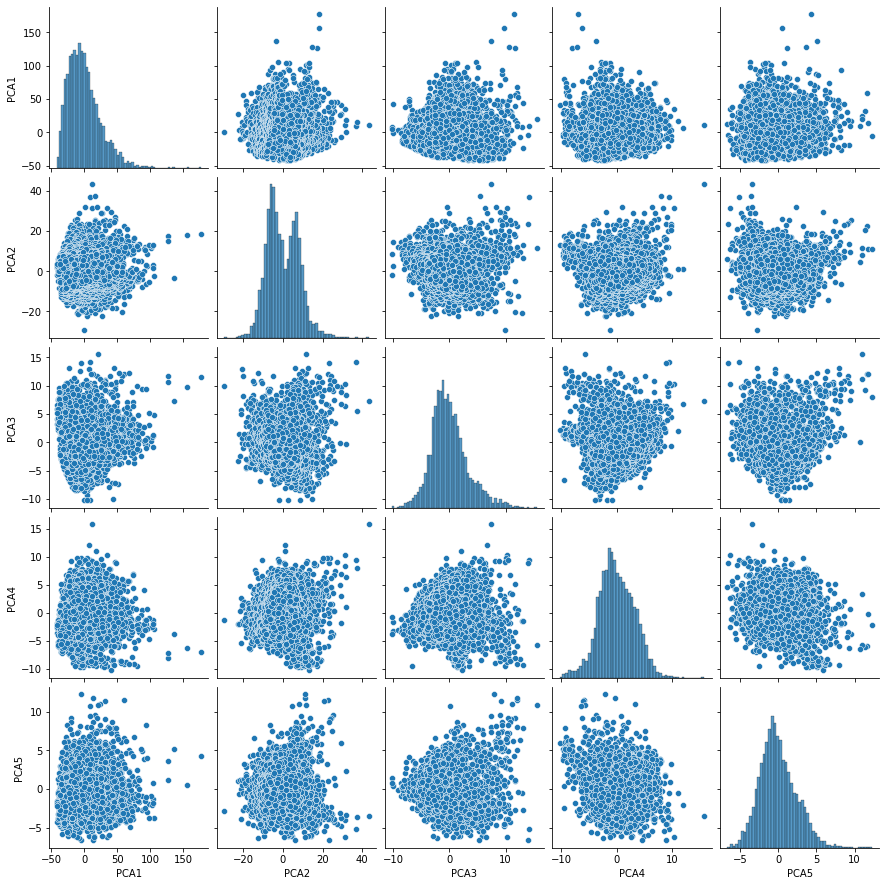

In [64]:
plot_pca(selected_data)

### Coefficient of variation

In [65]:
exp_id = "cv_pc_log2"

In [66]:
top_genes_var[exp_id] = (
    (log2_pc_test_data.std(axis=1) / log2_pc_test_data.mean(axis=1))
    .sort_values(ascending=False)
    .head(N_TOP_GENES_MAX_VARIANCE)
)

In [67]:
top_genes_var[exp_id]

gene_ens_id
ENSG00000248877.2    27.477263
ENSG00000252193.1    27.477263
ENSG00000201059.1    27.477263
ENSG00000207549.1    27.477263
ENSG00000268116.1    27.477263
                       ...    
ENSG00000226487.1    14.337352
ENSG00000277465.1    14.336492
ENSG00000265544.1    14.335722
ENSG00000240095.1    14.334759
ENSG00000271686.1    14.332173
Length: 5000, dtype: float64

### Mean absolute deviation

In [68]:
exp_id = "mad_pc_log2"

In [69]:
top_genes_var[exp_id] = (
    log2_pc_test_data.mad(axis=1)
    .sort_values(ascending=False)
    .head(N_TOP_GENES_MAX_VARIANCE)
)

In [70]:
top_genes_var[exp_id]

gene_ens_id
ENSG00000169429.10    3.532245
ENSG00000135245.9     3.150655
ENSG00000277632.1     2.916081
ENSG00000129824.15    2.739028
ENSG00000163631.16    2.721089
                        ...   
ENSG00000204310.12    0.704683
ENSG00000126216.13    0.704650
ENSG00000079308.16    0.704639
ENSG00000130723.18    0.704590
ENSG00000196843.15    0.704572
Length: 5000, dtype: float64

## Do selected genes with different methods overlap?

In [71]:
def overlap(x, y):
    ov = set(x).intersection(set(y))
    return len(ov)

In [72]:
assert overlap([1, 2, 3], [4, 5, 6]) == 0
assert overlap([1, 2, 3], [2, 3, 4]) == 2

In [73]:
genes_selection_methods = list(top_genes_var.keys())

display(genes_selection_methods)
assert len(genes_selection_methods) == 9

['var_raw',
 'cv_raw',
 'mad_raw',
 'var_log2',
 'cv_log2',
 'mad_log2',
 'var_pc_log2',
 'cv_pc_log2',
 'mad_pc_log2']

In [74]:
_gene_sets = np.array(
    [top_genes_var[x].index.tolist() for x in genes_selection_methods]
)

In [75]:
_gene_sets[:2]

array([['ENSG00000244734.3', 'ENSG00000188536.12', 'ENSG00000163220.10',
        ..., 'ENSG00000065911.11', 'ENSG00000163297.16',
        'ENSG00000259865.1'],
       ['ENSG00000252644.1', 'ENSG00000263890.1', 'ENSG00000278945.1',
        ..., 'ENSG00000250084.1', 'ENSG00000243543.8',
        'ENSG00000234686.1']], dtype='<U18')

In [76]:
assert overlap(_gene_sets[0], _gene_sets[0]) == 5000

In [77]:
_tmp = squareform(pdist(_gene_sets, metric=overlap))
np.fill_diagonal(_tmp, _gene_sets[0].shape[0])
_tmp = pd.DataFrame(
    _tmp, index=genes_selection_methods, columns=genes_selection_methods
)

display(_tmp)

,var_raw,cv_raw,mad_raw,var_log2,cv_log2,mad_log2,var_pc_log2,cv_pc_log2,mad_pc_log2
var_raw,5000.0,24.0,4785.0,65.0,616.0,46.0,3330.0,0.0,3197.0
cv_raw,24.0,5000.0,4.0,10.0,0.0,15.0,1.0,4828.0,1.0
mad_raw,4785.0,4.0,5000.0,22.0,554.0,11.0,3264.0,0.0,3165.0
var_log2,65.0,10.0,22.0,5000.0,0.0,4396.0,129.0,0.0,127.0
cv_log2,616.0,0.0,554.0,0.0,5000.0,0.0,1665.0,0.0,1751.0
mad_log2,46.0,15.0,11.0,4396.0,0.0,5000.0,92.0,0.0,89.0
var_pc_log2,3330.0,1.0,3264.0,129.0,1665.0,92.0,5000.0,0.0,4794.0
cv_pc_log2,0.0,4828.0,0.0,0.0,0.0,0.0,0.0,5000.0,0.0
mad_pc_log2,3197.0,1.0,3165.0,127.0,1751.0,89.0,4794.0,0.0,5000.0


Some methods select very different sets of highly variable genes. `cv_*` methods do not seem to agree much with the rest.

`var_*` and `mad_*` are similar, so it is expected their large overlap among the same data version. However, these two approaches (`var` and `mad`) also agree quite a lot between data versions `raw` and `pc_log2`.

In [78]:
# get list of methods that agree more with the rest
_tmp_top = (_tmp.sum() - 5000).sort_values(ascending=False)
display(_tmp_top)

assert _tmp_top.index[:4].tolist() == [
    "var_pc_log2",
    "mad_pc_log2",
    "var_raw",
    "mad_raw",
]

var_pc_log2    13275.0
mad_pc_log2    13124.0
var_raw        12063.0
mad_raw        11805.0
cv_raw          4883.0
cv_pc_log2      4828.0
var_log2        4749.0
mad_log2        4649.0
cv_log2         4586.0
dtype: float64

# How different are genes selected by `raw` and `pc_log2`?

Here I try to see how different are the expression distribution of genes selected using `raw` and `pc_log2`.

In [79]:
# get the rank for each method for easier comparison
genes_df = pd.DataFrame(top_genes_var).rank()

In [80]:
genes_df.shape

(20781, 9)

In [81]:
genes_df.head()

,var_raw,cv_raw,mad_raw,var_log2,cv_log2,mad_log2,var_pc_log2,cv_pc_log2,mad_pc_log2
gene_ens_id,,,,,,,,,
ENSG00000000419.12,1009.0,NaN,1344.0,NaN,NaN,NaN,2770.0,NaN,3021.0
ENSG00000000457.13,NaN,NaN,NaN,NaN,1967.0,NaN,NaN,NaN,NaN
ENSG00000000938.12,4833.0,NaN,4859.0,NaN,NaN,NaN,2498.0,NaN,2593.0
ENSG00000001084.10,NaN,NaN,NaN,NaN,1384.0,NaN,NaN,NaN,NaN
ENSG00000001167.14,879.0,NaN,944.0,NaN,NaN,NaN,1065.0,NaN,832.0


In [82]:
_tmp = genes_df.describe()
display(_tmp)

assert (_tmp.loc["min"] == 1.0).all()
assert (_tmp.loc["max"] == 5000.0).all()

,var_raw,cv_raw,mad_raw,var_log2,cv_log2,mad_log2,var_pc_log2,cv_pc_log2,mad_pc_log2
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000
mean,2500.500000,2500.500000,2500.500000,2500.500000,2500.500000,2500.500000,2500.500000,2500.50000,2500.500000
std,1443.520003,1441.858985,1443.520003,1443.520003,1443.520003,1443.520003,1443.520003,1441.76128,1443.520003
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000
25%,1250.750000,1250.750000,1250.750000,1250.750000,1250.750000,1250.750000,1250.750000,1250.75000,1250.750000
50%,2500.500000,2500.500000,2500.500000,2500.500000,2500.500000,2500.500000,2500.500000,2500.50000,2500.500000
75%,3750.250000,3641.500000,3750.250000,3750.250000,3750.250000,3750.250000,3750.250000,3626.50000,3750.250000
max,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000


In [83]:
cols = ["var_raw", "var_pc_log2"]

In [84]:
def plot_genes_kde(_gene_ids):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    axs = axs.flatten()

    # plot density on raw
    ax = axs[0]
    for gene_id in _gene_ids:
        a = sns.kdeplot(data=test_data.T, x=gene_id, ax=ax, label=gene_id)
        a.set_xlabel(None)
    ax.set_title("raw")

    # same genes, but plot density on pc_log2
    ax = axs[1]
    for gene_id in _gene_ids:
        a = sns.kdeplot(data=log2_pc_test_data.T, x=gene_id, ax=ax, label=gene_id)
        a.set_xlabel(None)
    ax.set_title("pseudocount (pc) log2")
    ax.legend()

## Genes selected in both raw and pc_log2

In [85]:
genes_df.loc[
    list(set(top_genes_var["var_raw"].index) & set(top_genes_var["var_pc_log2"].index)),
    cols,
].sort_values("var_raw", ascending=False).head()

,var_raw,var_pc_log2
gene_ens_id,,
ENSG00000244734.3,5000.0,2052.0
ENSG00000188536.12,4999.0,1600.0
ENSG00000163220.10,4998.0,4518.0
ENSG00000206172.8,4997.0,3921.0
ENSG00000223609.7,4996.0,2282.0


In [86]:
_gene_ids = [
    "ENSG00000163220.10",  # large in both
    "ENSG00000188536.12",  # smaller in log2
]

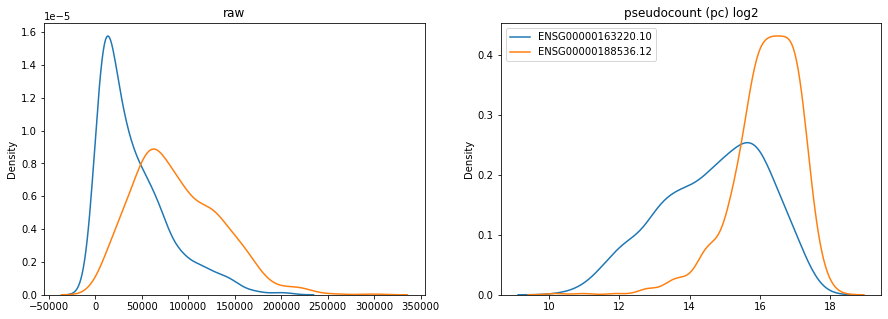

In [87]:
plot_genes_kde(_gene_ids)

## Genes selected in raw only

In [88]:
_tmp = genes_df.loc[
    set(top_genes_var["var_raw"].index) - set(top_genes_var["var_pc_log2"].index), cols
].sort_values("var_raw", ascending=False)

display(_tmp.shape)
display(_tmp.head())

(1670, 2)

,var_raw,var_pc_log2
gene_ens_id,,
ENSG00000087086.14,4994.0,NaN
ENSG00000234745.10,4991.0,NaN
ENSG00000198712.1,4986.0,NaN
ENSG00000198938.2,4981.0,NaN
ENSG00000210082.2,4980.0,NaN


In [89]:
_gene_ids = [
    "ENSG00000087086.14",
    "ENSG00000234745.10",
    "ENSG00000198712.1",
]

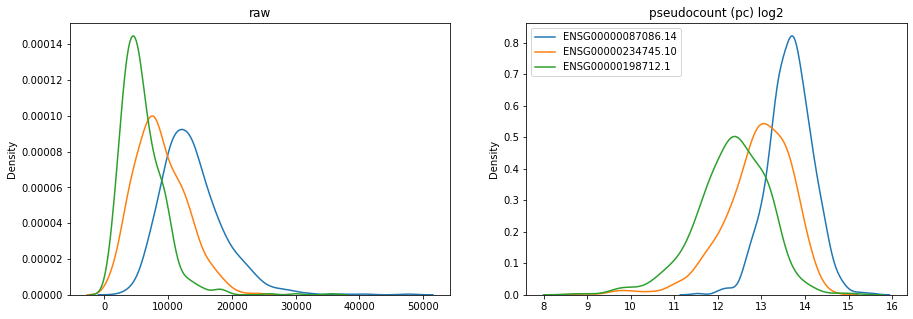

In [90]:
plot_genes_kde(_gene_ids)

These are the top three genes selected by `var_raw` and not by `var_pc_log2`. Distributions seem similar with different means.

## Genes selected in pc_log2 only

In [91]:
_tmp = genes_df.loc[
    set(top_genes_var["var_pc_log2"].index) - set(top_genes_var["var_raw"].index), cols
].sort_values("var_pc_log2", ascending=False)

display(_tmp.shape)
display(_tmp.head())

(1670, 2)

,var_raw,var_pc_log2
gene_ens_id,,
ENSG00000241112.1,NaN,4634.0
ENSG00000198692.9,NaN,4588.0
ENSG00000254288.1,NaN,4514.0
ENSG00000222335.1,NaN,4475.0
ENSG00000274256.1,NaN,4451.0


In [92]:
_gene_ids = [
    "ENSG00000241112.1",
    "ENSG00000198692.9",
    "ENSG00000254288.1",
]

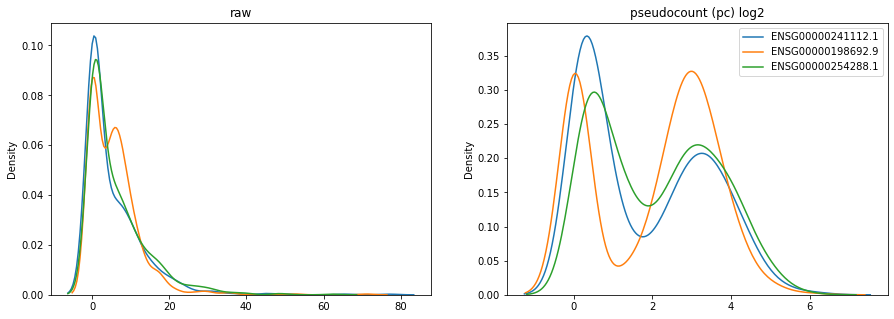

In [93]:
plot_genes_kde(_gene_ids)

**CONCLUSION:** Both `var_raw` (that is, the strategy that selects the top genes with highest variance on raw TPM-normalized data) and `var_pc_log2` (highest variance on pseudocount log2-transformed TPM-normalized data) agree on most genes. The difference seem to be that `pc_log2` is more sensitive to genes that are mostly not-expressed and expressed only on some conditions (bimodal distribution in the pc_log2 plot on the right), which might capture important genes such as transcriptor factors (see https://www.biorxiv.org/content/10.1101/2020.02.13.944777v1).

# Is correlation affected by a log-transformation?

In [94]:
_genes_intersect = sorted(
    list(set(top_genes_var["var_pc_log2"].index) & set(top_genes_var["var_raw"].index))
)
display(len(_genes_intersect))
display(_genes_intersect[:5])

assert len(_genes_intersect) == 3330

3330

['ENSG00000000419.12',
 'ENSG00000000938.12',
 'ENSG00000001167.14',
 'ENSG00000002549.12',
 'ENSG00000002586.18']

## Pearson

In [95]:
raw_corr = test_data.loc[_genes_intersect[:10]].T.corr(method="pearson")
display(raw_corr.shape)
display(raw_corr)

assert raw_corr.shape == (10, 10)

(10, 10)

gene_ens_id,ENSG00000000419.12,ENSG00000000938.12,ENSG00000001167.14,ENSG00000002549.12,ENSG00000002586.18,ENSG00000002834.17,ENSG00000002919.14,ENSG00000002933.7,ENSG00000003056.7,ENSG00000003400.14
gene_ens_id,,,,,,,,,,
ENSG00000000419.12,1.000000,0.654494,0.113629,0.303050,0.061668,0.681847,0.734699,0.013825,0.490846,0.685270
ENSG00000000938.12,0.654494,1.000000,0.113456,0.177975,-0.074602,0.816940,0.824963,0.006653,0.273223,0.566837
ENSG00000001167.14,0.113629,0.113456,1.000000,0.369233,0.461833,0.007316,-0.058136,0.037129,0.516353,0.374022
ENSG00000002549.12,0.303050,0.177975,0.369233,1.000000,0.429230,0.216385,0.188537,0.193344,0.685499,0.364559
ENSG00000002586.18,0.061668,-0.074602,0.461833,0.429230,1.000000,0.035417,-0.064559,0.208491,0.664762,0.342565
ENSG00000002834.17,0.681847,0.816940,0.007316,0.216385,0.035417,1.000000,0.910145,0.084594,0.394288,0.700317
ENSG00000002919.14,0.734699,0.824963,-0.058136,0.188537,-0.064559,0.910145,1.000000,0.047528,0.312313,0.641759
ENSG00000002933.7,0.013825,0.006653,0.037129,0.193344,0.208491,0.084594,0.047528,1.000000,0.199206,0.044698
ENSG00000003056.7,0.490846,0.273223,0.516353,0.685499,0.664762,0.394288,0.312313,0.199206,1.000000,0.645863


In [96]:
pc_log2_corr = log2_pc_test_data.loc[_genes_intersect[:10]].T.corr(method="pearson")
display(pc_log2_corr.shape)
display(pc_log2_corr)

assert raw_corr.shape == (10, 10)

(10, 10)

gene_ens_id,ENSG00000000419.12,ENSG00000000938.12,ENSG00000001167.14,ENSG00000002549.12,ENSG00000002586.18,ENSG00000002834.17,ENSG00000002919.14,ENSG00000002933.7,ENSG00000003056.7,ENSG00000003400.14
gene_ens_id,,,,,,,,,,
ENSG00000000419.12,1.000000,0.748887,0.227185,0.481435,0.197643,0.800319,0.823216,0.000667,0.634365,0.765270
ENSG00000000938.12,0.748887,1.000000,0.259208,0.405578,0.129908,0.848143,0.875524,0.042376,0.487175,0.663885
ENSG00000001167.14,0.227185,0.259208,1.000000,0.495755,0.527124,0.167317,0.072143,0.149598,0.596423,0.457583
ENSG00000002549.12,0.481435,0.405578,0.495755,1.000000,0.609763,0.431936,0.374256,0.277047,0.802594,0.547167
ENSG00000002586.18,0.197643,0.129908,0.527124,0.609763,1.000000,0.283018,0.132822,0.301317,0.739454,0.510008
ENSG00000002834.17,0.800319,0.848143,0.167317,0.431936,0.283018,1.000000,0.930079,0.053675,0.616410,0.814757
ENSG00000002919.14,0.823216,0.875524,0.072143,0.374256,0.132822,0.930079,1.000000,0.014769,0.501680,0.723488
ENSG00000002933.7,0.000667,0.042376,0.149598,0.277047,0.301317,0.053675,0.014769,1.000000,0.231121,0.058906
ENSG00000003056.7,0.634365,0.487175,0.596423,0.802594,0.739454,0.616410,0.501680,0.231121,1.000000,0.784051


In [97]:
_g0, _g1 = "ENSG00000000419.12", "ENSG00000000938.12"
assert raw_corr.loc[_g0, _g1] != pc_log2_corr.loc[_g0, _g1]

The Pearson correlation between raw and pc_log2 for the same pair of genes is not the same, since relationships are not exactly linear after the transformation.

## Spearman

In [98]:
raw_corr = test_data.loc[_genes_intersect[:10]].T.corr(method="spearman")
display(raw_corr.shape)
display(raw_corr)

assert raw_corr.shape == (10, 10)

(10, 10)

gene_ens_id,ENSG00000000419.12,ENSG00000000938.12,ENSG00000001167.14,ENSG00000002549.12,ENSG00000002586.18,ENSG00000002834.17,ENSG00000002919.14,ENSG00000002933.7,ENSG00000003056.7,ENSG00000003400.14
gene_ens_id,,,,,,,,,,
ENSG00000000419.12,1.000000,0.742602,0.170871,0.459836,0.110865,0.786595,0.816991,-0.004128,0.590756,0.747780
ENSG00000000938.12,0.742602,1.000000,0.182262,0.363975,0.005011,0.841355,0.869867,0.029919,0.407001,0.627511
ENSG00000001167.14,0.170871,0.182262,1.000000,0.466195,0.493971,0.073790,0.016023,0.151689,0.567713,0.401742
ENSG00000002549.12,0.459836,0.363975,0.466195,1.000000,0.588915,0.381523,0.343774,0.273445,0.802458,0.507189
ENSG00000002586.18,0.110865,0.005011,0.493971,0.588915,1.000000,0.140484,0.034642,0.294539,0.693362,0.413085
ENSG00000002834.17,0.786595,0.841355,0.073790,0.381523,0.140484,1.000000,0.930897,0.020230,0.524224,0.773483
ENSG00000002919.14,0.816991,0.869867,0.016023,0.343774,0.034642,0.930897,1.000000,0.005216,0.443321,0.704180
ENSG00000002933.7,-0.004128,0.029919,0.151689,0.273445,0.294539,0.020230,0.005216,1.000000,0.215946,0.032795
ENSG00000003056.7,0.590756,0.407001,0.567713,0.802458,0.693362,0.524224,0.443321,0.215946,1.000000,0.733803


In [99]:
pc_log2_corr = log2_pc_test_data.loc[_genes_intersect[:10]].T.corr(method="spearman")
display(pc_log2_corr.shape)
display(pc_log2_corr)

assert raw_corr.shape == (10, 10)

(10, 10)

gene_ens_id,ENSG00000000419.12,ENSG00000000938.12,ENSG00000001167.14,ENSG00000002549.12,ENSG00000002586.18,ENSG00000002834.17,ENSG00000002919.14,ENSG00000002933.7,ENSG00000003056.7,ENSG00000003400.14
gene_ens_id,,,,,,,,,,
ENSG00000000419.12,1.000000,0.742602,0.170871,0.459836,0.110865,0.786595,0.816991,-0.004128,0.590756,0.747780
ENSG00000000938.12,0.742602,1.000000,0.182262,0.363975,0.005011,0.841355,0.869867,0.029919,0.407001,0.627511
ENSG00000001167.14,0.170871,0.182262,1.000000,0.466195,0.493971,0.073790,0.016023,0.151689,0.567713,0.401742
ENSG00000002549.12,0.459836,0.363975,0.466195,1.000000,0.588915,0.381523,0.343774,0.273445,0.802458,0.507189
ENSG00000002586.18,0.110865,0.005011,0.493971,0.588915,1.000000,0.140484,0.034642,0.294539,0.693362,0.413085
ENSG00000002834.17,0.786595,0.841355,0.073790,0.381523,0.140484,1.000000,0.930897,0.020230,0.524224,0.773483
ENSG00000002919.14,0.816991,0.869867,0.016023,0.343774,0.034642,0.930897,1.000000,0.005216,0.443321,0.704180
ENSG00000002933.7,-0.004128,0.029919,0.151689,0.273445,0.294539,0.020230,0.005216,1.000000,0.215946,0.032795
ENSG00000003056.7,0.590756,0.407001,0.567713,0.802458,0.693362,0.524224,0.443321,0.215946,1.000000,0.733803


In [100]:
_g0, _g1 = "ENSG00000000419.12", "ENSG00000000938.12"
assert raw_corr.loc[_g0, _g1] == pc_log2_corr.loc[_g0, _g1]

The Spearman correlation between raw and pc_log2 for the same pair of genes is the same, since relationships are still monotonic.

# Select top genes for each tissue data file

Based on the previous findings, I select genes with both strategies `var_raw` and `var_pc_log2`.

Then I save, for both, the raw data (note that I only use the strategies to select genes, not to log-transform the data).

In [101]:
input_files = sorted(list(INPUT_DIR.glob("*.pkl")))
assert len(input_files) == 54, len(input_files)

display(input_files[:5])

[PosixPath('/opt/data/data/gtex_v8/data_by_tissue/gtex_v8_data_adipose_subcutaneous.pkl'),
 PosixPath('/opt/data/data/gtex_v8/data_by_tissue/gtex_v8_data_adipose_visceral_omentum.pkl'),
 PosixPath('/opt/data/data/gtex_v8/data_by_tissue/gtex_v8_data_adrenal_gland.pkl'),
 PosixPath('/opt/data/data/gtex_v8/data_by_tissue/gtex_v8_data_artery_aorta.pkl'),
 PosixPath('/opt/data/data/gtex_v8/data_by_tissue/gtex_v8_data_artery_coronary.pkl')]

## Run

In [102]:
pbar = tqdm(input_files, ncols=100)

for tissue_data_file in pbar:
    pbar.set_description(tissue_data_file.stem)

    tissue_data = pd.read_pickle(tissue_data_file)

    # var_raw
    top_genes_var = (
        tissue_data.var(axis=1)
        .sort_values(ascending=False)
        .head(N_TOP_GENES_MAX_VARIANCE)
    )
    selected_tissue_data = tissue_data.loc[top_genes_var.index]

    output_filename = f"{tissue_data_file.stem}-var_raw.pkl"
    selected_tissue_data.to_pickle(path=OUTPUT_DIR / output_filename)

    # var_pc_log2
    log2_tissue_data = np.log2(tissue_data + 1)

    top_genes_var = (
        log2_tissue_data.var(axis=1)
        .sort_values(ascending=False)
        .head(N_TOP_GENES_MAX_VARIANCE)
    )
    # save the same raw data, but with genes selected by var_pc_log2
    selected_tissue_data = tissue_data.loc[top_genes_var.index]

    output_filename = f"{tissue_data_file.stem}-var_pc_log2.pkl"
    selected_tissue_data.to_pickle(path=OUTPUT_DIR / output_filename)

gtex_v8_data_whole_blood: 100%|█████████████████████████████████████| 54/54 [00:21<00:00,  2.47it/s]


## Testing

In [103]:
_tmp_raw = pd.read_pickle(
    OUTPUT_DIR / "gtex_v8_data_brain_nucleus_accumbens_basal_ganglia-var_raw.pkl"
).sort_index()

_tmp_log2 = pd.read_pickle(
    OUTPUT_DIR / "gtex_v8_data_brain_nucleus_accumbens_basal_ganglia-var_pc_log2.pkl"
).sort_index()

In [104]:
display(_tmp_raw.shape)
assert _tmp_raw.shape == _tmp_log2.shape

(5000, 246)

In [105]:
assert _tmp_raw.columns.tolist() == _tmp_log2.columns.tolist()

In [106]:
_genes_intersect = sorted(list(set(_tmp_raw.index) & set(_tmp_log2.index)))
assert len(_genes_intersect) == 2926

In [107]:
# make sure the same data is stored
assert _tmp_raw.loc[_genes_intersect].equals(_tmp_log2.loc[_genes_intersect])

### raw

In [108]:
_tmp_raw.head()

,GTEX-1192X-0011-R6a-SM-DNZZB,GTEX-11DXW-0011-R6a-SM-DO11N,GTEX-11DXY-0011-R6a-SM-DNZZF,GTEX-11DYG-0011-R6a-SM-DO936,GTEX-11DZ1-0011-R6b-SM-DNZZG,GTEX-11GSP-0011-R6b-SM-57WBQ,GTEX-11NUK-0011-R6a-SM-DO93O,GTEX-11NV4-0011-R6a-SM-57WD5,GTEX-11O72-0011-R6a-SM-DNZZQ,GTEX-11OF3-0011-R6b-SM-57WBG,...,GTEX-ZAB4-0011-R6a-SM-4SOKD,GTEX-ZDXO-0011-R6a-SM-4WWCT,GTEX-ZE7O-0011-R6a-SM-57WCI,GTEX-ZE9C-0011-R6a-SM-4WWCW,GTEX-ZF28-0011-R6a-SM-4WKHI,GTEX-ZUA1-0011-R6b-SM-4YCDD,GTEX-ZV68-0011-R6a-SM-51MSR,GTEX-ZVT3-0011-R6a-SM-51MSU,GTEX-ZVZQ-0011-R6b-SM-57WAY,GTEX-ZXG5-0011-R6a-SM-57WBZ
gene_ens_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000000419.12,26.56,18.07,29.86,20.13,26.590,15.89,25.14,19.910,15.310,20.150,...,22.46,19.100,12.430,19.600,14.010,26.06,7.739,10.180,18.670,20.16
ENSG00000001084.10,18.55,8.78,17.55,16.36,11.410,12.86,14.81,12.440,6.365,13.450,...,17.78,12.210,4.577,9.539,7.669,30.63,4.899,5.318,13.860,13.64
ENSG00000001461.16,21.37,35.23,20.38,57.90,11.840,14.20,29.66,17.610,10.070,22.400,...,37.43,14.310,7.499,10.930,10.920,76.68,7.150,4.601,11.680,16.34
ENSG00000001497.16,24.92,21.58,30.64,27.65,14.070,21.70,19.74,17.390,17.160,20.170,...,22.29,25.940,15.490,14.440,10.620,37.98,6.389,8.341,20.320,26.06
ENSG00000001561.6,11.56,10.30,11.36,19.15,8.067,10.67,14.47,7.554,5.575,9.405,...,24.43,9.381,4.394,8.116,11.340,39.59,3.051,4.574,9.565,10.36


In [109]:
_tmp_desc = _tmp_raw.T.describe()
display(_tmp_desc)

assert _tmp_desc.loc["min"].min() == 0.0
assert _tmp_desc.loc["min"].max() == 37640.0

assert _tmp_desc.loc["max"].min() == 30.66
assert _tmp_desc.loc["max"].max() == 201000.0

gene_ens_id,ENSG00000000419.12,ENSG00000001084.10,ENSG00000001461.16,ENSG00000001497.16,ENSG00000001561.6,ENSG00000001629.9,ENSG00000002330.13,ENSG00000002549.12,ENSG00000002586.18,ENSG00000002834.17,...,ENSG00000279716.1,ENSG00000280237.3,ENSG00000280255.1,ENSG00000280294.1,ENSG00000280789.1,ENSG00000280800.1,ENSG00000281106.2,ENSG00000281383.1,ENSG00000282826.1,ENSG00000283375.1
count,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,...,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000
mean,23.316854,14.139098,18.878443,21.847248,11.936744,15.277480,46.710000,22.532524,48.640955,26.682028,...,12.387311,19.392576,15.136068,13.552272,42.731537,1.538290,16.715756,3.524699,12.912029,46.149268
std,12.381583,8.453523,13.237507,9.699263,8.602122,8.562956,13.042009,18.667395,25.736758,11.681936,...,8.651641,12.721590,11.008336,7.878688,17.857078,20.997576,21.196707,9.483100,8.638212,18.504901
min,3.373000,1.337000,1.180000,2.092000,1.199000,1.747000,14.370000,3.897000,8.825000,2.913000,...,0.128000,0.944800,0.311200,0.550900,4.600000,0.000000,0.067590,0.000000,0.962100,6.980000
25%,15.242500,7.997750,10.497500,14.532500,6.608500,9.722500,39.415000,13.605000,33.565000,17.887500,...,6.077750,9.964000,5.864250,7.152250,30.665000,0.036738,3.411750,0.500350,6.178250,32.830000
50%,22.420000,13.855000,17.025000,22.350000,10.450000,14.555000,47.290000,20.075000,44.315000,27.290000,...,11.350000,18.765000,13.610000,13.950000,43.505000,0.100550,13.395000,1.111000,10.910000,45.330000
75%,29.977500,18.280000,24.885000,28.397500,15.640000,19.715000,55.575000,26.565000,57.630000,33.900000,...,16.482500,25.427500,21.975000,18.870000,53.330000,0.226675,21.340000,3.024000,18.675000,56.892500
max,101.400000,74.880000,136.800000,44.890000,87.430000,82.940000,86.750000,240.500000,165.000000,59.140000,...,66.250000,99.580000,59.580000,47.070000,96.440000,329.500000,215.900000,103.100000,41.280000,123.000000


### pc_log2

In [110]:
_tmp_log2.head()

,GTEX-1192X-0011-R6a-SM-DNZZB,GTEX-11DXW-0011-R6a-SM-DO11N,GTEX-11DXY-0011-R6a-SM-DNZZF,GTEX-11DYG-0011-R6a-SM-DO936,GTEX-11DZ1-0011-R6b-SM-DNZZG,GTEX-11GSP-0011-R6b-SM-57WBQ,GTEX-11NUK-0011-R6a-SM-DO93O,GTEX-11NV4-0011-R6a-SM-57WD5,GTEX-11O72-0011-R6a-SM-DNZZQ,GTEX-11OF3-0011-R6b-SM-57WBG,...,GTEX-ZAB4-0011-R6a-SM-4SOKD,GTEX-ZDXO-0011-R6a-SM-4WWCT,GTEX-ZE7O-0011-R6a-SM-57WCI,GTEX-ZE9C-0011-R6a-SM-4WWCW,GTEX-ZF28-0011-R6a-SM-4WKHI,GTEX-ZUA1-0011-R6b-SM-4YCDD,GTEX-ZV68-0011-R6a-SM-51MSR,GTEX-ZVT3-0011-R6a-SM-51MSU,GTEX-ZVZQ-0011-R6b-SM-57WAY,GTEX-ZXG5-0011-R6a-SM-57WBZ
gene_ens_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000000419.12,26.56,18.070,29.860,20.13,26.590,15.890,25.140,19.910,15.310,20.150,...,22.46,19.100,12.430,19.600,14.010,26.06,7.739,10.180,18.670,20.160
ENSG00000000971.15,4.81,2.395,4.151,11.90,9.625,3.226,3.278,2.825,7.386,2.783,...,5.24,2.479,3.406,5.354,16.380,13.03,1.419,8.577,3.094,4.912
ENSG00000001084.10,18.55,8.780,17.550,16.36,11.410,12.860,14.810,12.440,6.365,13.450,...,17.78,12.210,4.577,9.539,7.669,30.63,4.899,5.318,13.860,13.640
ENSG00000001461.16,21.37,35.230,20.380,57.90,11.840,14.200,29.660,17.610,10.070,22.400,...,37.43,14.310,7.499,10.930,10.920,76.68,7.150,4.601,11.680,16.340
ENSG00000001497.16,24.92,21.580,30.640,27.65,14.070,21.700,19.740,17.390,17.160,20.170,...,22.29,25.940,15.490,14.440,10.620,37.98,6.389,8.341,20.320,26.060


In [111]:
# the stats are different than _tmp_raw
_tmp_desc = _tmp_log2.T.describe()
display(_tmp_desc)

assert _tmp_desc.loc["min"].min() == 0.0
assert _tmp_desc.loc["min"].max() == 201.4

assert _tmp_desc.loc["max"].min() == 5.824
assert _tmp_desc.loc["max"].max() == 15320.0

gene_ens_id,ENSG00000000419.12,ENSG00000000971.15,ENSG00000001084.10,ENSG00000001461.16,ENSG00000001497.16,ENSG00000001561.6,ENSG00000001630.15,ENSG00000001631.15,ENSG00000002549.12,ENSG00000003056.7,...,ENSG00000282164.2,ENSG00000282499.1,ENSG00000282608.1,ENSG00000282826.1,ENSG00000283183.1,ENSG00000283361.1,ENSG00000283366.1,ENSG00000283538.1,ENSG00000283709.1,ENSG00000284343.1
count,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,...,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000
mean,23.316854,7.099333,14.139098,18.878443,21.847248,11.936744,5.180572,8.764372,22.532524,19.293904,...,4.430942,1.269469,3.127371,12.912029,6.859047,2.065716,3.794452,2.001445,3.428694,1.024928
std,12.381583,5.958895,8.453523,13.237507,9.699263,8.602122,4.944276,4.499395,18.667395,12.507511,...,3.214435,1.618905,3.220588,8.638212,3.921471,3.348237,2.461334,1.618862,2.397112,2.527441
min,3.373000,0.647000,1.337000,1.180000,2.092000,1.199000,0.000000,0.634500,3.897000,0.894300,...,0.094220,0.000000,0.018690,0.962100,0.192000,0.036000,0.172000,0.000000,0.160500,0.000000
25%,15.242500,3.360750,7.997750,10.497500,14.532500,6.608500,1.465750,5.432500,13.605000,9.292000,...,1.655000,0.110900,1.009250,6.178250,3.948250,0.773575,1.826750,0.541025,1.741750,0.000000
50%,22.420000,5.036500,13.855000,17.025000,22.350000,10.450000,3.880000,8.652500,20.075000,17.865000,...,4.142000,0.686450,2.167000,10.910000,6.742000,1.205500,3.546000,1.828500,3.008000,0.000000
75%,29.977500,8.871000,18.280000,24.885000,28.397500,15.640000,7.524750,11.890000,26.565000,26.552500,...,6.717250,1.767500,3.912250,18.675000,9.414250,1.959500,5.355250,3.002500,4.636750,0.420250
max,101.400000,50.850000,74.880000,136.800000,44.890000,87.430000,29.440000,24.050000,240.500000,96.140000,...,14.310000,9.451000,22.810000,41.280000,22.040000,28.780000,13.700000,7.817000,18.240000,18.550000
